In [ ]:
"""
Cambios en la arquitectura de la red neuronal convolucional

    - Valor de funcion de regularizacion L2 a 0.01
    - Se añadio resnet50 como base de la red
    - Se agrego funcion para guardar el mejor modelo
"""

## Instalar bibliotecas necesarias

In [ ]:
!pip install torch                    # Install the PyTorch library for deep learning.
!pip install pandas                   # Install the Pandas library for data manipulation.
!pip install scikit-learn             # Install scikit-learn for machine learning tasks.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import torch
from torchvision.io import read_image
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader,ConcatDataset
from sklearn.preprocessing import LabelEncoder
from torch import nn
from torch import optim
import datetime
from sklearn.preprocessing import StandardScaler
from PIL import Image

## Acceder a drive

In [2]:
from google.colab import drive

# Montar Google Drive en /content/drive
drive.mount('/content/drive')

# Listar archivos en el directorio raíz de Google Drive
!ls '/content/drive/MyDrive/Dataset/Mosaico'

Mounted at /content/drive
dataset.csv  Imagenes  test.csv  train.csv


In [3]:
# --> Definir si viene desde local o drive

ruta = '/content/drive/MyDrive/Dataset/Mosaico/'
# ruta = '../Dataset/Mosaico/'

ruta_modelo = '/content/drive/MyDrive/Dataset/'

## Lectura de dataset train

In [4]:
train = pd.read_csv(f'{ruta}train.csv')
train.head()

,bathrooms,bedrooms,area,zipcode,mosaic_image,price
0,2.0,4,7841,60016,78.png,299000
1,2.5,3,3233,62234,70.png,259000
2,1.0,2,1110,94501,204.png,649000
3,3.0,4,2256,62214,72.png,144900
4,2.0,2,2036,92276,287.png,175000


## Clases y funciones auxiliares

In [5]:
class CustomImageDataset(Dataset):
    def __init__(self, df, transform=None):
        """
        Constructor de la clase que inicializa el dataset personalizado.
        df: DataFrame que contiene los datos (rutas de las imágenes y características numéricas).
        transform: Transformaciones opcionales que se aplicarán a las imágenes (si se proporciona).
        """
        self.df = df  # Guardar el DataFrame que contiene las rutas de imágenes y las características numéricas.
        self.transform = transform  # Almacenar las transformaciones opcionales para las imágenes.

        # Seleccionar las columnas que contienen las características numéricas que deseas estandarizar.
        self.numeric_features = ['bedrooms', 'bathrooms', 'area', 'zipcode']

        # Inicializar el estandarizador de sklearn (StandardScaler) y ajustarlo a las características numéricas.
        self.scaler = StandardScaler()

        # Aplicar el estandarizador a las columnas de características numéricas y actualizar el DataFrame.
        self.df[self.numeric_features] = self.scaler.fit_transform(self.df[self.numeric_features])

    def __len__(self):
        """Devuelve el número de muestras en el dataset."""
        return len(self.df)

    def __getitem__(self, idx):
        """
        Obtiene una muestra del dataset en el índice `idx`.
        """
        # Obtener la ruta de la imagen correspondiente al índice dado.
        img_path = self.df.loc[idx, 'mosaic_image']

        # Leer la imagen utilizando PIL.Image.open para que las transformaciones funcionen correctamente.
        mosaic_image = Image.open(f"{ruta}Imagenes/{img_path}").convert("RGB")

        # Obtener los valores de las características numéricas para la muestra actual.
        bathrooms = torch.tensor(self.df.loc[idx, 'bathrooms'], dtype=torch.float32)
        bedrooms = torch.tensor(self.df.loc[idx, 'bedrooms'], dtype=torch.float32)
        area = torch.tensor(self.df.loc[idx, 'area'], dtype=torch.float32)
        zipcode = torch.tensor(self.df.loc[idx, 'zipcode'], dtype=torch.float32)
        price = torch.tensor(self.df.loc[idx, 'price'], dtype=torch.float32)  # Precio como el valor objetivo.

        # Aplicar las transformaciones a la imagen si se proporcionaron en el constructor.
        if self.transform:
            mosaic_image = self.transform(mosaic_image)

        # Concatenar las características numéricas (bathrooms, bedrooms, area, zipcode) en un único tensor.
        numeric_features = torch.hstack((bathrooms, bedrooms, area, zipcode))

        # Devolver la imagen procesada, las características numéricas estandarizadas y el precio objetivo.
        return mosaic_image, numeric_features, price

In [6]:
import matplotlib.pyplot as plt
import torch

# Función para deshacer la normalización (inverso de transforms.Normalize)
def denormalize(tensor, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1) # Ajustar la media a la forma del tensor
    std = torch.tensor(std).view(3, 1, 1)   # Ajustar la desviación estándar a la forma del tensor
    return tensor * std + mean

# Función para mostrar una imagen
def show_image(image_tensor, title=None, apply_desnormalize=False):
    # Deshacer la normalización con los valores de ImageNet
    if apply_desnormalize:
        image_tensor = denormalize(image_tensor, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

    # Asegurarse de que los valores de los píxeles estén entre 0 y 1 para matplotlib
    image_tensor = torch.clamp(image_tensor, 0, 1)

    # Convertir el tensor a numpy
    image = image_tensor.permute(1, 2, 0).cpu().numpy()  # Cambia las dimensiones de (C, H, W) a (H, W, C)

    # Mostrar la imagen
    plt.imshow(image)  # Mostrar sin conversión a uint8 porque los valores están en rango [0, 1]
    if title:
        plt.title(title)
    plt.axis('off')  # Quitar los ejes
    plt.show()


In [7]:
from torchvision import models

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()

        # Cargar el modelo preentrenado ResNet50
        self.image_features_ = models.resnet50(pretrained=True)

        # Eliminar la última capa de clasificación (fully connected) de ResNet50
        self.image_features_ = nn.Sequential(*list(self.image_features_.children())[:-1])

        # Procesamiento de las características numéricas (4 características)
        self.numeric_features_ = nn.Sequential(
            nn.Linear(4, 64),   # Aquí usas 4 datos numéricos
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(64, 64*3),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(64*3, 64*3*3),
            nn.ReLU(inplace=True),
        )

        # Capa final que combina las características visuales y numéricas
        self.combined_features_ = nn.Sequential(
            nn.Linear(2048 + 64*3*3, 64*3*3*2*2),  # 2048 provienen de ResNet50 + numéricas
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(64*3*3*2*2, 64*3*3*2),
            nn.ReLU(inplace=True),
            nn.Linear(64*3*3*2, 64),
            nn.Linear(64, 1),  # Predicción final
        )

    def forward(self, x, y):
        # Pasar las imágenes por ResNet50 para obtener las características visuales
        x = self.image_features_(x)
        # print(x.shape)
        x = x.view(x.size(0), -1)
        # print(x.shape)

        # Pasar las características numéricas por la red densa
        y = self.numeric_features_(y)

        # Combinar características visuales y numéricas
        z = torch.cat((x, y), dim=1)
        # print(z.shape)

        # Pasar las características combinadas por las capas finales
        z = self.combined_features_(z)

        return z.squeeze(1)

In [8]:
class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, yhat, y):
        return torch.sqrt(self.mse(yhat, y))

In [9]:
def test_loop(dataloader, model, loss_fn, device):
    """
    Función para realizar un bucle de prueba en el conjunto de datos de prueba.
    """
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0
    total_error = 0

    with torch.no_grad():
        for batch_idx, (imgs, numeric_features, price) in enumerate(dataloader):
            # Mandar datos al dispositivo
            imgs = imgs.to(device)
            numeric_features = numeric_features.to(device)
            price = price.to(device)

            # Predecir
            pred = model(imgs, numeric_features)

            # Calcular pérdida
            batch_loss = loss_fn(pred, price).item()
            test_loss += batch_loss
            total_error += torch.abs(pred - price).sum().item()

            # Imprimir la pérdida de cada batch
            #print(f"Batch {batch_idx+1}/{num_batches}, Batch Loss: {batch_loss:.4f}")

    # Calcular pérdida y error promedio
    test_loss /= num_batches
    avg_error = total_error / size

    #print(f"Test Error: \n Avg loss: {test_loss:.6f}, Avg error: {avg_error:.6f} \n")
    return test_loss

In [10]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader, val_loader, device):
    """
    Función para realizar el bucle de entrenamiento.
    """
    train_losses = []
    val_losses = []
    prev_loss = 0

    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        model.train()

        for batch_idx, (imgs, numeric_features, price) in enumerate(train_loader):
            imgs = imgs.to(device)
            numeric_features = numeric_features.to(device)
            price = price.to(device)

            output = model(imgs, numeric_features)

            loss = loss_fn(output, price)

            # L2 Regularization
            l2_lambda = 0.01
            l2_norm = sum(p.pow(2).sum() for p in model.parameters())
            loss = loss + l2_lambda * l2_norm

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

            # Imprimir la pérdida en cada batch
            #print(f"Epoch {epoch}, Batch {batch_idx+1}/{len(train_loader)}, Batch Loss: {loss.item():.4f}")

        loss_train /= len(train_loader)
        train_losses.append(loss_train)
        #print(f"Epoch {epoch}, Epoch Loss: {loss_train:.4f}")

        model.eval()
        val_loss = test_loop(dataloader=val_loader, model=model, loss_fn=loss_fn, device=device)
        val_losses.append(val_loss)

        # Verificar si la pérdida de validación disminuye
        if epoch == 1:
            prev_loss = val_loss
        else:
            if val_loss < prev_loss:
                # Guardar el modelo si la pérdida de validación disminuye
                torch.save(model, f"{ruta_modelo}model_resnet50_l2_lambda.pth")
                prev_loss = val_loss
                print(f"Modelo guardado en epoch {epoch} con loss {val_loss}")

        # Imprimir la pérdida promedio en cada epoch
        print(f'[+]{datetime.datetime.now()} Epoch {epoch}, Av.Training loss {loss_train}')
        print(f'\t[+]{datetime.datetime.now()} Epoch {epoch}, Av.Validation loss {val_loss}')
    #print(prev_loss)
    return train_losses, val_losses

## Ejecución de entrenamiento

In [11]:
# --> Aumentar el tamaño de las muestras de entrenamiento y validación.

# Dataset sin transformaciones adicionales
data1 = CustomImageDataset(df=train, transform=transforms.Compose([
    transforms.Resize(256),                               # Redimensionar a 256x256
    transforms.CenterCrop(224),                           # Recortar al centro para obtener 224x224
    transforms.ToTensor(),                                # Convertir la imagen a un tensor
    transforms.Normalize(
        (0.485, 0.456, 0.406),                            # Media de ImageNet
        (0.229, 0.224, 0.225)                             # Desviación estándar de ImageNet
    )
]))

# Dataset con transformación de normalización para ResNet50
data2 = CustomImageDataset(df=train, transform=transforms.Compose([
    transforms.Resize(256),                               # Redimensionar a 256x256
    transforms.CenterCrop(224),                           # Recortar al centro para obtener 224x224
    transforms.ToTensor(),                                # Convertir la imagen a un tensor
    transforms.Normalize(
        (0.485, 0.456, 0.406),                            # Media de ImageNet
        (0.229, 0.224, 0.225)                             # Desviación estándar de ImageNet
    )
]))

# Dataset con desplazamiento de canales (RGB a BGR) y normalización para ResNet50
data3 = CustomImageDataset(df=train, transform=transforms.Compose([
    transforms.Resize(256),                               # Redimensionar a 256x256
    transforms.CenterCrop(224),                           # Recortar al centro para obtener 224x224
    transforms.ToTensor(),                                # Convertir la imagen a un tensor
    transforms.Lambda(lambda img: img[[2, 1, 0], :, :]),  # Cambiar los canales RGB a BGR (se aplica después de ToTensor)
    transforms.Normalize(
        (0.485, 0.456, 0.406),                            # Media de ImageNet
        (0.229, 0.224, 0.225)                             # Desviación estándar de ImageNet
    )
]))

# Dataset con volteo horizontal y normalización para ResNet50
data4 = CustomImageDataset(df=train, transform=transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.8),               # Volteo horizontal con una probabilidad de 80%
    transforms.Resize(256),                               # Redimensionar a 256x256
    transforms.CenterCrop(224),                           # Recortar al centro para obtener 224x224
    transforms.ToTensor(),                                # Convertir la imagen a un tensor
    transforms.Normalize(
        (0.485, 0.456, 0.406),                            # Media de ImageNet
        (0.229, 0.224, 0.225)                             # Desviación estándar de ImageNet
    )
]))

# Dataset con volteo vertical y normalización para ResNet50
data5 = CustomImageDataset(df=train, transform=transforms.Compose([
    transforms.RandomVerticalFlip(p=0.8),                 # Volteo vertical con una probabilidad de 80%
    transforms.Resize(256),                               # Redimensionar a 256x256
    transforms.CenterCrop(224),                           # Recortar al centro para obtener 224x224
    transforms.ToTensor(),                                # Convertir la imagen a un tensor
    transforms.Normalize(
        (0.485, 0.456, 0.406),                            # Media de ImageNet
        (0.229, 0.224, 0.225)                             # Desviación estándar de ImageNet
    )
]))

# Dataset con desenfoque gaussiano y normalización para ResNet50
data6 = CustomImageDataset(df=train, transform=transforms.Compose([
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.Resize(256),                               # Redimensionar a 256x256
    transforms.CenterCrop(224),                           # Recortar al centro para obtener 224x224
    transforms.ToTensor(),                                # Convertir la imagen a un tensor
    transforms.Normalize(
        (0.485, 0.456, 0.406),                            # Media de ImageNet
        (0.229, 0.224, 0.225)                             # Desviación estándar de ImageNet
    )
]))



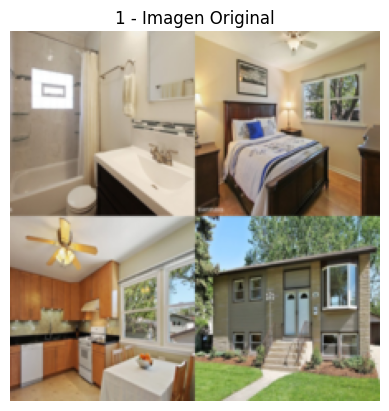

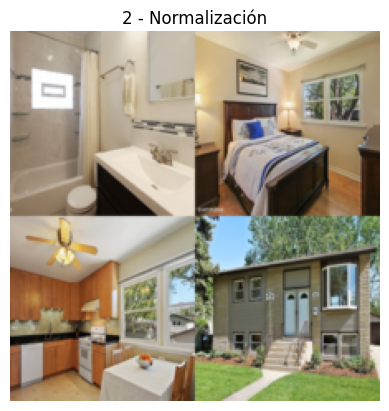

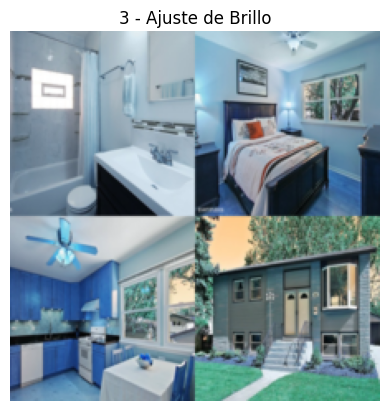

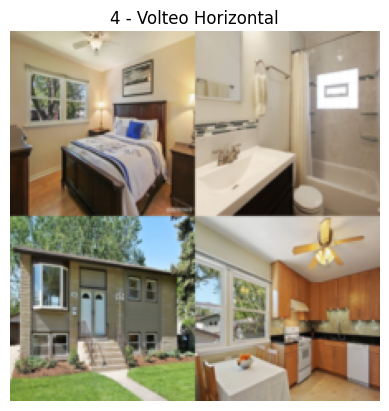

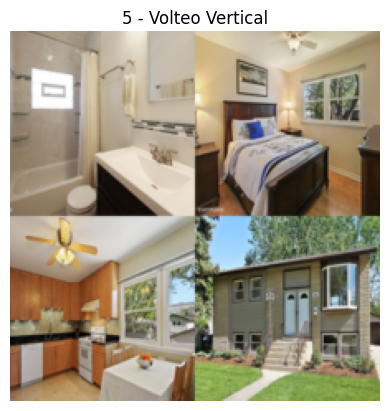

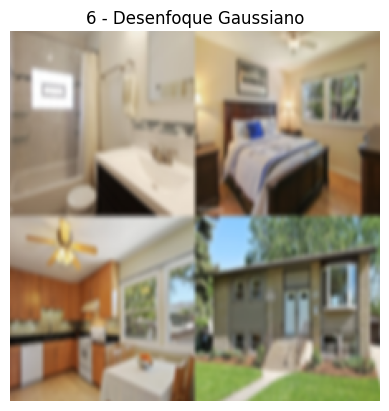

In [12]:
# --> Ver las imágenes de entrenamiento con diferentes transformaciones.

lista_titulos = [
    'Imagen Original', 'Normalización', 'Ajuste de Brillo',
    'Volteo Horizontal', 'Volteo Vertical', 'Desenfoque Gaussiano'
    ]

# Visualizar la primera imagen de cada conjunto de datos
datasets = [data1, data2, data3, data4, data5, data6]

# Iterar
for i, dataset in enumerate(datasets, 1):
    # Obtener la primera muestra del conjunto de datos (imagen, características numéricas, precio)
    image, _, _ = dataset[0]

    show_image(image, title=f"{i} - {lista_titulos[i-1]}", apply_desnormalize=True)

In [13]:
# --> Combinar los conjuntos de datos en un solo conjunto de datos
conjunto_datos = ConcatDataset((data1, data2, data3, data4, data5, data6))

valor_train = int(0.9 * len(conjunto_datos))
valor_val = len(conjunto_datos) - valor_train

print(f"Train: {valor_train} Val: {valor_val}")

Train: 2597 Val: 289


In [14]:
# --> Dividir el conjunto de datos en conjuntos de entrenamiento y validación
train_data,val_data=torch.utils.data.random_split(ConcatDataset((data1, data2, data3, data4, data5, data6)), [valor_train, valor_val])

# --> Eliminar las variables que ya no se necesitan
del data1, data2, data3, data4, data5, data6

In [15]:
# --> Definir dispositivo
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Dispositivo: {device}")

# --> Definir modelo
model = NeuralNetwork().to(device)              # Modelo de red neuronal mandarlo al dispositivo (GPU)

# --> Definir optimizador y la función de pérdida
# optimizer=optim.Adam(model.parameters(),1e-3)   # Adam optimizer para optimización
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
# loss_fn=nn.MSELoss()                          # Mean Squared Error Loss para regresión
loss_fn = RMSELoss()                            # RMSE Loss para regresión

Dispositivo: cuda


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 177MB/s]


In [16]:
# --> Crear los dataloaders
batch_size_train = 53
batch_size_val = 17

if device == 'cuda':
    train_dataloader = DataLoader(train_data, batch_size=batch_size_train, shuffle=True, num_workers=4)
    val_dataloader = DataLoader(val_data, batch_size=batch_size_val, shuffle=False, num_workers=4)
else:
    train_dataloader = DataLoader(train_data, batch_size=batch_size_train, shuffle=True)
    val_dataloader = DataLoader(val_data, batch_size=batch_size_val, shuffle=False)

print(f"Muestras de train: {len(train_data)} - Baches {len(train_dataloader)}")
print(f"Muestras de test: {len(val_data)} - Baches {len(val_dataloader)}")

Muestras de train: 2597 - Baches 49
Muestras de test: 289 - Baches 17


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [17]:
# Entrenamiento
n_epochs = 175
train_losses, val_losses = training_loop(
    n_epochs=n_epochs,
    optimizer=optimizer,
    model=model,
    loss_fn=loss_fn,
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    device=device
)

[+]2024-10-20 19:19:33.794132 Epoch 1, Av.Training loss 625719.1552933673
	[+]2024-10-20 19:19:33.795452 Epoch 1, Av.Validation loss 513181.4430147059
Modelo guardado en epoch 2 con loss 441947.1801470588
[+]2024-10-20 19:20:19.553697 Epoch 2, Av.Training loss 395366.47959183675
	[+]2024-10-20 19:20:19.554044 Epoch 2, Av.Validation loss 441947.1801470588
Modelo guardado en epoch 3 con loss 299774.609375
[+]2024-10-20 19:21:07.924964 Epoch 3, Av.Training loss 348728.16167091834
	[+]2024-10-20 19:21:07.925418 Epoch 3, Av.Validation loss 299774.609375
[+]2024-10-20 19:21:57.548199 Epoch 4, Av.Training loss 280782.5031887755
	[+]2024-10-20 19:21:57.548357 Epoch 4, Av.Validation loss 309596.2362132353
[+]2024-10-20 19:22:45.520003 Epoch 5, Av.Training loss 268412.5650510204
	[+]2024-10-20 19:22:45.520187 Epoch 5, Av.Validation loss 312665.0643382353
Modelo guardado en epoch 6 con loss 184314.5137867647
[+]2024-10-20 19:23:32.913893 Epoch 6, Av.Training loss 254681.8469387755
	[+]2024-10-20 

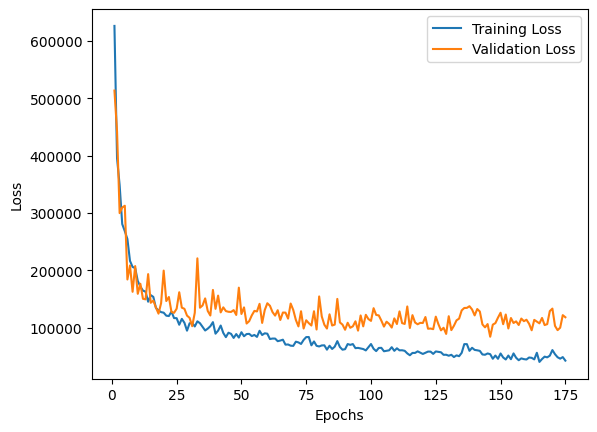

In [18]:
import matplotlib.pyplot as plt

# Graficar las pérdidas
plt.plot(range(1, n_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, n_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Probar modelo

In [30]:
# Cargar modelo
model = torch.load(f"{ruta_modelo}model_resnet50_l2_lambda.pth")

<ipython-input-30-00c2b62f0c4a>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(f"{ruta_modelo}model_resnet50_l2_lambda.pth")


In [31]:
# Importar dataset
test = pd.read_csv(f'{ruta}test.csv')
test.head()

,bathrooms,bedrooms,area,zipcode,mosaic_image,price
0,2.5,3,1915,92021,117.png,485000
1,2.5,3,2248,92677,132.png,1199000
2,1.0,3,1132,96019,154.png,170000
3,4.0,6,3375,92880,245.png,538000
4,2.5,3,2733,91901,84.png,689000


In [32]:
# Crear dataset
test_data = CustomImageDataset(df=test, transform=transforms.Compose([
    transforms.Resize(256),                               # Redimensionar a 256x256
    transforms.CenterCrop(224),                           # Recortar al centro para obtener 224x224
    transforms.ToTensor(),                                # Convertir la imagen a un tensor
    transforms.Normalize(
        (0.485, 0.456, 0.406),                            # Media de ImageNet
        (0.229, 0.224, 0.225)                             # Desviación estándar de ImageNet
    )
]))

In [33]:
# Crear dataloader
test_loader = DataLoader(test_data, batch_size=9, shuffle=False)

In [34]:
# Predecir precios de casa

def predict(model, test_loader, device):
    model.eval()  # Poner el modelo en modo evaluación
    predictions = []
    actuals = []

    with torch.no_grad():  # Deshabilitar el cálculo de gradientes
        for batch_idx, (imgs, numeric_features, target) in enumerate(test_loader):
            # Mover los datos a la GPU si está disponible
            imgs = imgs.to(device)
            numeric_features = numeric_features.to(device)
            target = target.to(device)

            # Forward pass: obtener las predicciones
            output = model(imgs, numeric_features)

            # Almacenar las predicciones y los valores reales (en CPU para facilidad)
            predictions.append(output.cpu().numpy())
            actuals.append(target.cpu().numpy())

    # Convertir las listas de predicciones y reales en arrays de NumPy
    predictions = np.concatenate(predictions, axis=0)
    actuals = np.concatenate(actuals, axis=0)

    return predictions, actuals

In [35]:
# Llamar a la función de predicción
predictions, actuals = predict(model, test_loader, device)

# Mostrar algunas predicciones junto con los valores reales
for i in range(10):  # Mostrar los primeros 10 ejemplos
    print(f"Predicción: {predictions[i]}, Valor real: {actuals[i]}")


Predicción: 610371.1875, Valor real: 485000.0
Predicción: 406886.40625, Valor real: 1199000.0
Predicción: 349068.84375, Valor real: 170000.0
Predicción: 612523.9375, Valor real: 538000.0
Predicción: 734567.3125, Valor real: 689000.0
Predicción: 467903.65625, Valor real: 118900.0
Predicción: 719251.625, Valor real: 799000.0
Predicción: 889640.5625, Valor real: 895000.0
Predicción: 637855.5625, Valor real: 599000.0
Predicción: 395443.21875, Valor real: 535000.0


In [36]:
# Evaluacion

from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calcular RMSE
rmse = np.sqrt(mean_squared_error(actuals, predictions))
print(f"RMSE en el conjunto de prueba: {rmse:.4f}")

# Calcular MAE
mae = mean_absolute_error(actuals, predictions)
print(f"MAE en el conjunto de prueba: {mae:.4f}")


RMSE en el conjunto de prueba: 341356.2812
MAE en el conjunto de prueba: 218461.9375


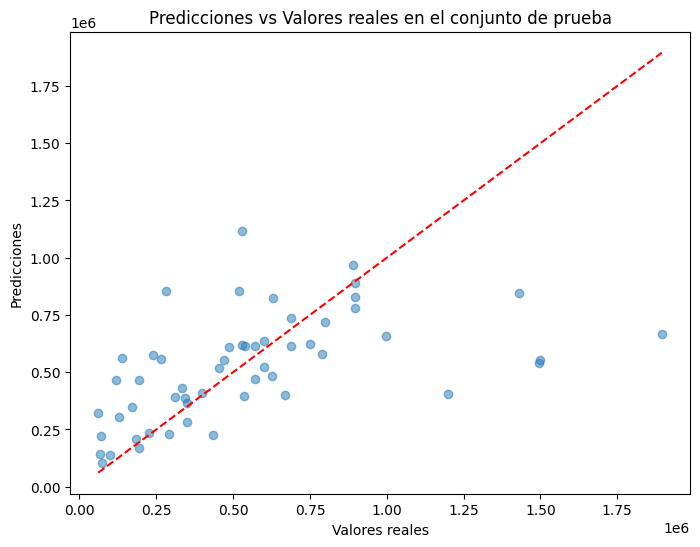

In [37]:
import matplotlib.pyplot as plt

# Graficar las predicciones vs los valores reales
plt.figure(figsize=(8, 6))
plt.scatter(actuals, predictions, alpha=0.5)
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'r--')  # Línea de igualdad (predicción = realidad)
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores reales en el conjunto de prueba')
plt.show()
